In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import pandas as pd
import numpy as np
import datetime
from collections import Counter
from tqdm import tqdm
tqdm.pandas() 
import re

# 시각화
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from wordcloud import WordCloud
plt.rcParams["font.family"] = 'NanumGothic'


# 토픽모델링 관련 패키지 & 모듈
import gensim
from gensim import corpora , models
from gensim.models.callbacks import CoherenceMetric 
from gensim.models.coherencemodel import CoherenceModel
import logging

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/home/ryu/.conda/envs/ryuvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## 데이터 불러오기

In [2]:
data = pd.read_csv('/home/ryu/2023text/final/textrank_results_0605.csv')
data.head(3)

,title,timeline,year,month,sentences,summarization
0,서울대 연구팀 또 표절 의혹 이종호 장관 아들 1저자 논문,before,2022,7,['거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 ...,['거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 ...
1,중부지방에 5 40 소나기 낮 최고 35도 폭염,before,2022,7,['우산행렬 금요일인 1일은 늦은 오후부터 저녁 사이 중부지방을 중심으로 천둥 번개...,['폭염특보가 발표된 일부 강원 영동 중 남부와 충청권 남부지방 제주도를 중심으로 ...
2,삼성 세계 첫 3나노 양산 TSMC 잡을까,before,2022,7,"['삼성전자가 세계 최초로 3나노 기술을 적용한 반도체를 생산하기 시작했습니다', ...","['이곳에서 3나노미터 공정이 적용된 세계 최초의 반도체가 양산되기 시작했습니다',..."


In [3]:
data['summarization'] = data['summarization'].str.replace('[','').str.replace(']','').str.replace('\'','')

/tmp/ipykernel_87548/436337807.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['summarization'] = data['summarization'].str.replace('[','').str.replace(']','').str.replace('\'','')


## 불용어처리

In [4]:
from konlpy.tag import Okt
okt = Okt()

In [7]:
with open('/home/ryu/AInews_stopwords.txt') as f:
    stopwords = []
    while True:
        stopword = f.readline().strip()
        if not stopword: break
        stopwords.append(stopword)

stopwords[:10]

['하다', '있다', '등', '되다', '것', '수', '고', '를', '위', '돼다']

In [8]:
def pos_tagging(news, which_tags):
    tokens = []
    pos_tag = okt.pos(news, stem=True)
    for word, tag in pos_tag:
        if tag in which_tags and word not in stopwords:
            tokens.append(word)
    
    return tokens

In [9]:
data['tokenized'] = data['summarization'].progress_apply(lambda x: pos_tagging(x, ['Adjective','Noun','Verb']))
data['tokenized'].head()

100%|██████████| 39719/39719 [34:39<00:00, 19.10it/s]


0    [거의, 같다, 문장, 반복, 등장, 서울대, 연구, 진실성, 조사, 위원회, 열다...
1    [폭염, 특보, 발표, 일부, 강원, 영동, 중, 남부, 충청권, 남부, 지방, 제...
2    [곳, 나노미터, 공정, 적용, 세계, 최초, 반도체, 양산, 시작, 전자, 세계,...
3    [신한은행, 따르다, 이번, 인사, 본점, 영업, 점, 장기, 근속, 직원, 순환,...
4    [남이공, 대학교, 지난달, 제주도, 호텔, 골든, 데이지, 서귀포, 오션, 미래,...
Name: tokenized, dtype: object

In [10]:
data.head()

,title,timeline,year,month,sentences,summarization,tokenized
0,서울대 연구팀 또 표절 의혹 이종호 장관 아들 1저자 논문,before,2022,7,['거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 ...,거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 인공...,"[거의, 같다, 문장, 반복, 등장, 서울대, 연구, 진실성, 조사, 위원회, 열다..."
1,중부지방에 5 40 소나기 낮 최고 35도 폭염,before,2022,7,['우산행렬 금요일인 1일은 늦은 오후부터 저녁 사이 중부지방을 중심으로 천둥 번개...,폭염특보가 발표된 일부 강원 영동 중 남부와 충청권 남부지방 제주도를 중심으로 최고...,"[폭염, 특보, 발표, 일부, 강원, 영동, 중, 남부, 충청권, 남부, 지방, 제..."
2,삼성 세계 첫 3나노 양산 TSMC 잡을까,before,2022,7,"['삼성전자가 세계 최초로 3나노 기술을 적용한 반도체를 생산하기 시작했습니다', ...","이곳에서 3나노미터 공정이 적용된 세계 최초의 반도체가 양산되기 시작했습니다, 삼성...","[곳, 나노미터, 공정, 적용, 세계, 최초, 반도체, 양산, 시작, 전자, 세계,..."
3,신한은행 ESG본부 신설 하반기 정기 인사,before,2022,7,['AI 인사 업그레이드 금융사고 예방 위해 장기근속 직원 순환근무 신한은행은 1일...,신한은행에 따르면 이번 인사는 본점 영업점 장기근속 직원의 순환 근무를 통해 각종 ...,"[신한은행, 따르다, 이번, 인사, 본점, 영업, 점, 장기, 근속, 직원, 순환,..."
4,영남이공대 미래 신산업 수요특화형 AI IoT 교육,before,2022,7,['영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에...,영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에서 ...,"[남이공, 대학교, 지난달, 제주도, 호텔, 골든, 데이지, 서귀포, 오션, 미래,..."


In [11]:
data.to_csv('/home/ryu/2023text/final/lda_tokens.csv', index=False)

In [27]:
# tokenization 처리 된 데이터 가져와서 리스트 형식으로 바꾸기
data = pd.read_csv('/home/ryu/2023text/final/processed_for_topic_0618.csv')
data.head()

,title,timeline,year,month,sentences,summarization,filtered_texts
0,서울대 연구팀 또 표절 의혹 이종호 장관 아들 1저자 논문,before,2022,7,['거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 ...,거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 인공...,거의 문장 반복 등장 서울대 연구 진실성 조사 위원회 열다 사진 한경 서울대 팀 표...
1,중부지방에 5 40 소나기 낮 최고 35도 폭염,before,2022,7,['우산행렬 금요일인 1일은 늦은 오후부터 저녁 사이 중부지방을 중심으로 천둥 번개...,폭염특보가 발표된 일부 강원 영동 중 남부와 충청권 남부지방 제주도를 중심으로 최고...,폭염 특보 발표 일부 강원 영동 중 남부 충청권 남부 지방 제주도 중심 최고 체감온...
2,삼성 세계 첫 3나노 양산 TSMC 잡을까,before,2022,7,"['삼성전자가 세계 최초로 3나노 기술을 적용한 반도체를 생산하기 시작했습니다', ...","이곳에서 3나노미터 공정이 적용된 세계 최초의 반도체가 양산되기 시작했습니다, 삼성...",곳 나노미터 공정 적용 세계 최초 반도체 양산 시작 전자 세계 최초 나노 적용 반도...
3,신한은행 ESG본부 신설 하반기 정기 인사,before,2022,7,['AI 인사 업그레이드 금융사고 예방 위해 장기근속 직원 순환근무 신한은행은 1일...,신한은행에 따르면 이번 인사는 본점 영업점 장기근속 직원의 순환 근무를 통해 각종 ...,신한은행 따르다 이번 인사 본점 영업 점 장기 근속 직원 순환 근무 각종 금융 사고...
4,영남이공대 미래 신산업 수요특화형 AI IoT 교육,before,2022,7,['영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에...,영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에서 ...,남이공 대학교 지난달 제주도 호텔 골든 데이지 서귀포 오션 미래 산업 수요 특 화형...


In [28]:
def to_list(text):
    tokens = text.split(' ')
    return tokens

In [29]:
data['tokenized'] = data['filtered_texts'].progress_apply(lambda x: to_list(x))
data.head()

100%|██████████| 39719/39719 [00:01<00:00, 35384.57it/s]


,title,timeline,year,month,sentences,summarization,filtered_texts,tokenized
0,서울대 연구팀 또 표절 의혹 이종호 장관 아들 1저자 논문,before,2022,7,['거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 ...,거의 같은 문장 반복해서 등장서울대 연구진실성조사위원회 열어사진 한경DB서울대 인공...,거의 문장 반복 등장 서울대 연구 진실성 조사 위원회 열다 사진 한경 서울대 팀 표...,"[거의, 문장, 반복, 등장, 서울대, 연구, 진실성, 조사, 위원회, 열다, 사진..."
1,중부지방에 5 40 소나기 낮 최고 35도 폭염,before,2022,7,['우산행렬 금요일인 1일은 늦은 오후부터 저녁 사이 중부지방을 중심으로 천둥 번개...,폭염특보가 발표된 일부 강원 영동 중 남부와 충청권 남부지방 제주도를 중심으로 최고...,폭염 특보 발표 일부 강원 영동 중 남부 충청권 남부 지방 제주도 중심 최고 체감온...,"[폭염, 특보, 발표, 일부, 강원, 영동, 중, 남부, 충청권, 남부, 지방, 제..."
2,삼성 세계 첫 3나노 양산 TSMC 잡을까,before,2022,7,"['삼성전자가 세계 최초로 3나노 기술을 적용한 반도체를 생산하기 시작했습니다', ...","이곳에서 3나노미터 공정이 적용된 세계 최초의 반도체가 양산되기 시작했습니다, 삼성...",곳 나노미터 공정 적용 세계 최초 반도체 양산 시작 전자 세계 최초 나노 적용 반도...,"[곳, 나노미터, 공정, 적용, 세계, 최초, 반도체, 양산, 시작, 전자, 세계,..."
3,신한은행 ESG본부 신설 하반기 정기 인사,before,2022,7,['AI 인사 업그레이드 금융사고 예방 위해 장기근속 직원 순환근무 신한은행은 1일...,신한은행에 따르면 이번 인사는 본점 영업점 장기근속 직원의 순환 근무를 통해 각종 ...,신한은행 따르다 이번 인사 본점 영업 점 장기 근속 직원 순환 근무 각종 금융 사고...,"[신한은행, 따르다, 이번, 인사, 본점, 영업, 점, 장기, 근속, 직원, 순환,..."
4,영남이공대 미래 신산업 수요특화형 AI IoT 교육,before,2022,7,['영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에...,영남이공대학교는 지난달 27일부터 7월1일까지 제주도 호텔골든데이지 서귀포오션에서 ...,남이공 대학교 지난달 제주도 호텔 골든 데이지 서귀포 오션 미래 산업 수요 특 화형...,"[남이공, 대학교, 지난달, 제주도, 호텔, 골든, 데이지, 서귀포, 오션, 미래,..."


In [30]:
data = data[data['timeline']=='after']
data.head()

,title,timeline,year,month,sentences,summarization,filtered_texts,tokenized
18775,뿌리부터 튼튼한 인공지능 인재 양성 광주전략회의 첫 개최,after,2022,11,['기사내용 요약광주시 시의회 교육청이 함께하는 최고 정책논의 플랫폼 가동 강기정 ...,광주시는 지난 29일 오후 남구 송하동 광주실감콘텐츠큐브에서 제1회 광주전략회의를 ...,광주시 지난 오후 남구 송하동 광주 실감 콘텐츠 큐브 광주 전략 회의 열다 의회 의...,"[광주시, 지난, 오후, 남구, 송하동, 광주, 실감, 콘텐츠, 큐브, 광주, 전략..."
18776,UNIST 울주군 인공지능 미래인재 탄생,after,2022,11,['6개월간 대장정 인공지능 프로젝트 결과 발표울주군 1 2학년 고등학생 UNIST...,xx0 Studio는 울주군 소재 고등학교 1 2학년 학생들을 대상으로 UNIST ...,늘다 울주군 소재 고등학교 학년 학생 대상 재학생 멘토 교육 실습 제공 프로그램 월...,"[늘다, 울주군, 소재, 고등학교, 학년, 학생, 대상, 재학생, 멘토, 교육, 실..."
18777,인공지능은 새로운 장르의 음악을 창조할 수 있을까,after,2022,11,"['지식인싸 들의 프리미엄 지식레시피 지식구독플랫폼 스브스프리미엄 스프입니다', '...",월드컵에서 독일이 절대 강자인 건 바로 이것 축구에서 승부를 가리는 최후의 수단인 ...,월드컵 독일 절대 강 건 바로 축구 승부 가리다 최후 수단 승부차기 흔하다 러시안룰...,"[월드컵, 독일, 절대, 강, 건, 바로, 축구, 승부, 가리다, 최후, 수단, 승..."
18778,네이버 서비스 출시 과정서 인공지능 윤리 적용 강화한다,after,2022,11,['서울대와 협업한 AI 윤리 자문 프로세스 CHEC 공개네이버가 지난해에 이어 지...,박우철 리더는 네이버 서비스 출시 과정에서 AI 윤리 준칙 적용을 강화하기 위한 네...,박우철 리더 네이버 출시 과정 윤리 준칙 적용 강화하다 네이버 윤리 자문 프로세스 ...,"[박우철, 리더, 네이버, 출시, 과정, 윤리, 준칙, 적용, 강화하다, 네이버, ..."
18779,인공지능 언어 능력 평가 대상에 가천대학교 1인 1메뉴 팀,after,2022,11,['29일 열린 시상식 모습 국립국어원은 올해 인공지능 언어 능력 평가 대회 에서 ...,29일 열린 시상식 모습 국립국어원은 올해 인공지능 언어 능력 평가 대회 에서 가천...,열리다 시상식 모습 국립국어원 올해 언어 능력 평가 대회 가천대 학교 인 메뉴 팀 ...,"[열리다, 시상식, 모습, 국립국어원, 올해, 언어, 능력, 평가, 대회, 가천대,..."


In [31]:
len(data)

20944

In [32]:
# 데이터를 모델 input에 맞게 변환
dictionary = corpora.Dictionary(data['tokenized']) # 각 단어에 번호 할당
dictionary.filter_extremes(no_below=10, no_above=0.9) # 10개의 문서 미만으로 등장하는 단어는 제외, 전체의 90% 이상으로 자주 등장하는 단어는 제외
corpus = [dictionary.doc2bow(text) for text in data['tokenized']]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 5), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 2), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 7), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 3), (57, 1), (58, 1), (59, 1), (60, 7), (61, 3), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 2), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 6), (89, 1)]


In [33]:
# 번호 할당 잘 되었는지 확인
print(dictionary[66])

중등


In [34]:
# Compute Coherence Score
def compute_values(dictionary,corpus,texts,limit,start=2,step=3):
    '''
    - coherence_score
    의미 : 토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
    주 용도 : 해당 모델이 얼마나 실제로 의미 있는 결과를 내는지 확인
    '''
    coherence_values=[]
    model_list=[]
    for num_topics in tqdm(range(start,limit,step)):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=num_topics, passes=30, iterations=1000, random_state=52)
        '''
        passes : Number of passes through the corpus during training (epoch와 유사기능, 전체 데이터 셋의 학습 횟수)
        iterations : Maximum number of iterations through the corpus when inferring the topic distribution of a corpus(1 pass시 파라미터 업데이트 횟수)
        '''
        model_list.append(model)
        coherencemodel= CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

/tmp/ipykernel_12355/902229789.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_list,coherence_values=compute_values(dictionary=dictionary,corpus=corpus,texts=list(np.array(data['tokenized'].tolist())),
100%|██████████| 21/21 [2:58:55<00:00, 511.21s/it]  


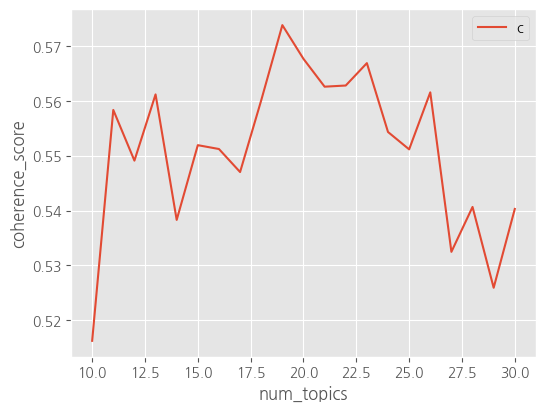

In [35]:
## coherence score확인

limit=31     # 확인하고 싶은 max 토픽 수
start=10     # 확인할 시작 토픽 수
step=1      # 1개씩 topic수 늘려가며 확인

model_list,coherence_values=compute_values(dictionary=dictionary,corpus=corpus,texts=list(np.array(data['tokenized'].tolist())), 
                                           start=start,limit=limit,step=step)

# coherence score 시각화
x=range(start,limit,step)
plt.subplots(figsize=(10,4),constrained_layout=True)

# coherence_score
plt.subplot(1,2,1)
plt.plot(x,coherence_values)
plt.xlabel('num_topics')
plt.ylabel('coherence_score')
plt.legend('coherence_values',loc='best')

plt.show()

In [36]:
for i, value in enumerate(coherence_values):
    print(f'model #{i}, coherence_value: {value}')

model #0, coherence_value: 0.5162342141372431
model #1, coherence_value: 0.5583698582904671
model #2, coherence_value: 0.5491180119400504
model #3, coherence_value: 0.5612015440086282
model #4, coherence_value: 0.5383005611576906
model #5, coherence_value: 0.5519391409560633
model #6, coherence_value: 0.5512377607870487
model #7, coherence_value: 0.5470348600868631
model #8, coherence_value: 0.5601253677070085
model #9, coherence_value: 0.5738480050738205
model #10, coherence_value: 0.5676899575649405
model #11, coherence_value: 0.5626130086220629
model #12, coherence_value: 0.5628248514660574
model #13, coherence_value: 0.5669101599274349
model #14, coherence_value: 0.554345124196716
model #15, coherence_value: 0.5511753510243773
model #16, coherence_value: 0.5615776769572968
model #17, coherence_value: 0.5324706381150138
model #18, coherence_value: 0.5406640587908688
model #19, coherence_value: 0.5259159827002932
model #20, coherence_value: 0.5402974250089907


In [37]:
# 주제 확인
ldamodel = model_list[9] # coherence score가 높은 모델 선택

# 토픽별 키워드 확인
topics = ldamodel.print_topics(num_words=30) # 한 토픽 당 확인할 단어 수
for topic in topics:
    print(topic)

(0, '0.050*"챗" + 0.018*"생" + 0.018*"늘다" + 0.018*"구글" + 0.015*"오픈" + 0.015*"챗봇" + 0.011*"검색" + 0.010*"대화" + 0.009*"활용" + 0.009*"오다" + 0.008*"사용" + 0.008*"정보" + 0.008*"질문" + 0.007*"공개" + 0.007*"인간" + 0.007*"학습" + 0.007*"모델" + 0.006*"언어" + 0.006*"만들다" + 0.006*"답변" + 0.006*"마이크로소프트" + 0.005*"엔진" + 0.005*"않다" + 0.005*"데이터" + 0.005*"대한" + 0.005*"답" + 0.004*"나오다" + 0.004*"따르다" + 0.004*"대해" + 0.004*"사람"')
(1, '0.022*"카카오" + 0.013*"고객" + 0.011*"제공" + 0.009*"앱" + 0.008*"금융" + 0.008*"업" + 0.007*"이용" + 0.007*"상품" + 0.006*"밝히다" + 0.006*"상담" + 0.005*"위해" + 0.005*"스테이지" + 0.005*"운영" + 0.005*"받다" + 0.005*"보험" + 0.005*"은행" + 0.005*"도입" + 0.004*"관리" + 0.004*"확대" + 0.004*"확인" + 0.004*"개인" + 0.004*"연금" + 0.004*"택시" + 0.004*"톡" + 0.004*"대상" + 0.003*"따르다" + 0.003*"비" + 0.003*"출시" + 0.003*"범죄" + 0.003*"이용자"')
(2, '0.070*"산업" + 0.029*"분야" + 0.023*"지원" + 0.020*"첨단" + 0.020*"미래" + 0.014*"바이오" + 0.013*"육성" + 0.012*"협력" + 0.011*"연구" + 0.011*"혁신" + 0.011*"전략" + 0.010*"구축" + 0.010*"인재" + 0.010*"양성" + 0.010*"국가" + 0

In [ ]:
# 수치값 없이 키워드 확인
for topic in topics:
    for word in re.split("[\*+]", topic[1].replace('\'','').replace('\"','')):
        try:
            float(word)
        except:
            print(word,end='')
    print()

In [38]:
# 토픽 결과 시각화
lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(lda_viz, 'LDA_v0619_after_18topics.html') # LDA 결과 html로 저장
# lda_viz
# pyLDAvis.show(lda_viz)

'''
원의 반경 : 해당토픽의 크기
원의 위치 : 거리가 가까울 수록 비슷한 토픽 -> 시각화 했을 때 원끼리 거리가 떨어져 있는 것이 좋음
λ : 0이 될수록 토픽 간 차이가 많이 나는 단어, 1이 될수록 토픽별로 자주 등장하는 단어를 의미 
'''

/home/ryu/.conda/envs/ryuvenv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/ryu/.conda/envs/ryuvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ryu/.conda/envs/ryuvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ryu/.conda/envs/ryuvenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


'\n원의 반경 : 해당토픽의 크기\n원의 위치 : 거리가 가까울 수록 비슷한 토픽 -> 시각화 했을 때 원끼리 거리가 떨어져 있는 것이 좋음\nλ : 0이 될수록 토픽 간 차이가 많이 나는 단어, 1이 될수록 토픽별로 자주 등장하는 단어를 의미 \n'